In [6]:
import pandas as pd  
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD


In [8]:
file_loc = "../Resources/ModelData/train_test_data.csv"
customer_complaints_df = pd.read_csv(file_loc)
customer_complaints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7684 entries, 0 to 7683
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Product                       7684 non-null   object
 1   Consumer complaint narrative  7684 non-null   object
dtypes: object(2)
memory usage: 120.2+ KB


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Extract features and target
X = customer_complaints_df['Consumer complaint narrative']
y = customer_complaints_df['Product']
print(y)
# Preprocess categorical features using one-hot encoding
label_encoder = LabelEncoder()
labels = customer_complaints_df['Product']
y = label_encoder.fit_transform(labels)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Use the top 5000 words
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


# Train a Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)

# Evaluate Random Forest
print("=== Logistic Regression Results ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred_rf))
# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# classification_rep = classification_report(y_test, y_pred)

# accuracy

0       Checking or savings account
1                       Credit card
2                       Credit card
3                       Credit card
4       Checking or savings account
                   ...             
7679                    Credit card
7680                    Credit card
7681    Checking or savings account
7682                    Credit card
7683    Checking or savings account
Name: Product, Length: 7684, dtype: object
[0 1 1 ... 0 1 0]
[1 0 0 ... 0 1 0]
=== Logistic Regression Results ===
Accuracy: 0.9238776837996097
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       755
           1       0.93      0.92      0.92       782

    accuracy                           0.92      1537
   macro avg       0.92      0.92      0.92      1537
weighted avg       0.92      0.92      0.92      1537



In [ ]:
# Function to parse classification report
def parse_classification_report(report):
    lines = report.strip().split("\n")
    rows = []
    for line in lines[1:]:  # Skip header
        tokens = line.split()
        if len(tokens) < 2:
            continue  # Skip empty lines or invalid ones
        if tokens[0] in ["accuracy", "macro", "weighted"]:  # Handle summary metrics
            metric_name = " ".join(tokens[:2]) if len(tokens) == 5 else tokens[0]
            metrics = tokens[-3:]
            rows.append([metric_name] + [None] + metrics)
        else:
            label = " ".join(tokens[:-4])
            metrics = tokens[-4:]
            rows.append([label] + metrics)

    return pd.DataFrame(rows, columns=["Class", "Precision", "Recall", "F1-Score", "Support"])
# Evaluate Random Forest
print("=== Logistic Regression Results ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))
# # Convert report to DataFrame
# report_df = parse_classification_report(classification_rep)

# # Display the DataFrame
# print(report_df)

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 0.08067664281067013
Mean Squared Error (MSE): 0.08067664281067013
R-squared (R2): 0.6771938144679122


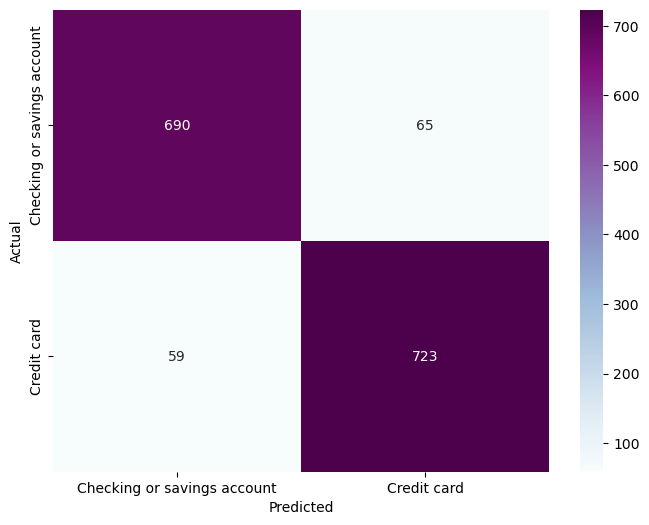

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix
# Visualize confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="BuPu",xticklabels=customer_complaints_df['Product'].unique(),yticklabels=customer_complaints_df['Product'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
# Save the plot
plt.savefig("../images/confusion_matrix_heatmap_for_logistic_regression.png")
plt.show()

In [16]:
import pickle

# Save the model
with open('../Resources/ModelData/supervised_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Save the vectorizer
with open('../Resources/ModelData/tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(tfidf_vectorizer, vectorizer_file)

print("Model and vectorizer saved with pickle.")

Model and vectorizer saved with pickle.


## Random Forest Model

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# # Train Random Forest Classifier
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_model.fit(X_train_tfidf, y_train)

# # Predict with Random Forest
# y_pred_rf = rf_model.predict(X_test_tfidf)

# # Evaluate Random Forest
# print("=== Random Forest Results ===")
# print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")

In [ ]:
# import pickle

# # Save the model
# with open('../Resources/ModelData/random_forest_model.pkl', 'wb') as model_file:
#     pickle.dump(model, model_file)

# # Save the vectorizer
# with open('../Resources/ModelData/tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
#     pickle.dump(tfidf_vectorizer, vectorizer_file)

# print("Random Forest Model and vectorizer saved with pickle.")

In [41]:
# # Load the model
# with open('../Resources/ModelData/random_forest_model.pkl', 'rb') as model_file:
#     loaded_model = pickle.load(model_file)

# # Load the vectorizer
# with open('../Resources/ModelData/tfidf_vectorizer.pkl', 'rb') as vectorizer_file:
#     loaded_vectorizer = pickle.load(vectorizer_file)

# # Predict with the loaded model
# sample_text = ['Because of my health problems I was unable to pay my bills on time. The bank added 10 late fees for insufficient funds. I asked for reimbursement but was denied. The fees are XXXX XXXX {$35.00} each= {$350.00}']
# sample_tfidf = loaded_vectorizer.transform(sample_text)
# predicted_class = loaded_model.predict(sample_tfidf)
# print("Predicted class:", predicted_class)

Predicted class: [0]
